# CDS-102: Lab 14 Workbook
## Name: Helena Gray
### May 4, 2017

In [10]:
# Run this code block to load the Tidyverse package
.libPaths(new = "~/Rlibs")
library(tidyverse)
library(modelr)
library(readxl)
library(rpart)
library(stats)
library(randomForest)
library(rattle)
library(rpart.plot)
library(RColorBrewer)
library(caret)

# To change the size of any plots, copy the code snippet
# below, uncomment it, and set the size of the width
# and height.
# Note: All subsequent figures will use the same size,
# unless you change the options() snippet and run it
# again.

# options(repr.plot.width=6, repr.plot.height=4)

R session is headless; GTK+ not initialized.
Rattle: A free graphical interface for data mining with R.
Version 4.1.0 Copyright (c) 2006-2015 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



# Lab Introduction

For the final lab for the semester, we will work through a tutorial-style
Jupyter notebook that gives a "real-world" demonstration of how to use machine
learning to model a dataset, use cross-validation to check it, and from there
make predictions. We employ a "black box" approach, and make use of useful
R packages that handle much of the hard work for us. In essence, you will
see that you do not need to have a deep and sophisticated knowledge of the
models and machine learning algorithms in order to do useful work!

First, we need to install two more packages into our SageMathCloud environment.
Run the command below to install them (you only need to do this once). **Note:
This may take a couple of minutes to finish running.**

In [12]:
# Install packages that you don't currently have
install.packages(c("rattle", "rpart.plot"), lib = c("~/Rlibs"))


The downloaded source packages are in
	‘/tmp/RtmpTu0cVi/downloaded_packages’


# Dataset overview

We will use the Titanic dataset to demonstrate the power and flexibility of the machine learning
packages available within R. You may remember working through this dataset for Homework 1 in CDS-101.
If not, no worries, we recap the basic details of the dataset here.

![A photograph of the *Titanic* leaving Southampton on April 10, 1912](titanic_photograph.jpg)

This dataset contains information about
passengers on the *Titanic*, the British passenger liner that crashed into an
iceberg during its maiden voyage and sank early in the morning on April
15, 1912. The tragedy stands out as one of the deadliest commericial maritime
disasters during peacetime in history. More than half of the passengers and
crew died, due in large part to poor safety standards, such as not having
enough lifeboats or not ensuring all lifeboats were filled to capacity during
evacuation.

This dataset presents the most up-to-date knowledge about the passengers that
were on the *Titanic*, including whether or not they survived. We will be using
the dataset to build models that try to predict whether or not a passenger survived or died.

The columns in the dataset are:

| Variable | Description
| :---: | :----: |
| passengerid | A unique index used to uniquely identify each passenger in the dataset 
| pclass    | Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)                          
| survival  | Survival (0 = No; 1 = Yes)                                           
| name      | Name                                                                 
| sex       | Sex                                                                  
| age       | Age                                                                  
| sibsp     | Number of Siblings/Spouses Aboard                                    
| parch     | Number of Parents/Children Aboard                                    
| ticket    | Ticket Number                                                        
| fare      | Passenger Fare (British pound)                                       
| cabin     | Cabin                                                                
| embarked  | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) 

Also note that the following definitions were used for `sibsp` and `parch`:

| Relative | Description
| ---: | :---
| Sibling: | Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic      |
| Spouse:  | Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored) |
| Parent:  | Mother or Father of Passenger Aboard Titanic                                 |
| Child:   | Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic          |



## Loading the dataset

The dataset is saved as an Excel file in the xlsx format. We can use the `read_excel()`
function that is part of the `readxl` library (loaded at the top of the page), to
extract all the relevant information. For convenience, we also redefine several columns as the `factor`
data type instead of the `character` data type.

In [3]:
# Load and prepare dataset
dataset <- suppressMessages(read_excel("titanic3.xlsx"))
dataset <- dataset %>%
  mutate(
      passengerid = as.integer(passengerid),
      pclass = as.factor(pclass),
      survived = as.factor(survived),
      name = as.factor(name),
      sex = as.factor(sex),
      sibsp = as.factor(sibsp),
      parch = as.factor(parch),
      ticket = as.factor(ticket),
      fare = as.double(fare),
      cabin = as.factor(cabin),
      embarked = as.factor(embarked)
  ) %>%
  select(passengerid, survived, pclass, name, everything())

We check the dataset to make sure that everything loaded correctly.

In [4]:
glimpse(dataset)

Observations: 1,309
Variables: 12
$ passengerid <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, ...
$ survived    <fctr> 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, ...
$ pclass      <fctr> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ name        <fctr> Allen, Miss. Elisabeth Walton, Allison, Master. Hudson...
$ sex         <fctr> female, male, female, male, female, male, female, male...
$ age         <dbl> 29.0000, 0.9167, 2.0000, 30.0000, 25.0000, 48.0000, 63....
$ sibsp       <fctr> 0, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...
$ parch       <fctr> 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...
$ ticket      <fctr> 24160, 113781, 113781, 113781, 113781, 19952, 13502, 1...
$ fare        <dbl> 211.3375, 151.5500, 151.5500, 151.5500, 151.5500, 26.55...
$ cabin       <fctr> B5, C22 C26, C22 C26, C22 C26, C22 C26, E12, D7, A36, ...
$ embarked    <fctr> S, S, S, S, S, S, S, S, S, C, C, C, C, S, S, S, C, C, ...


# Problem statement

The following key questions will drive our analysis,

1. Can we build a model that predicts whether a given passenger will survive or die using only the passenger information contained in the dataset?
2. How accurate can we make the predictions?
3. Do different model families (linear models versus decision trees) significantly differ in their performance, or are they statistically equivalent?
4. What are the variables in the dataset that are the most important in determining survivorship?

# Generalized Linear Models (GLM)

During the last 3 weeks, we have worked with linear models. For the labs, we only considered one-term models while in CDS-101 we also explored multi-term models as well. These are all examples of the standard class of linear models, which have the general form $f(x_1, x_2, \ldots, x_n) = a_1 x_1 + a_2 x_2 + \ldots + a_n x_n$. Note that, if you use transformations as we did in labs 12 and 13, this amounts to changing the fitting parameters $a_1, a_2, \ldots, a_n$. 

The models we've used have assumed that the response variable (`survived` in this dataset) is continuous. However, for this model, it is not,
it is categorical and binary (a passenger either survives or doesn't). The `lm()` function isn't built to handle this all that well, so we
use the `glm()` function instead. The initials mean *Generalized Linear Model*. These, as the name implies, work in more situations than `lm()`, 
including when the response vector isn't continuous.

The code below sets up a calculation using `glm()`, and models the data using the passengers ages only. Run it, then print out the model to see
what you find.

In [5]:
dataset.model.glm.malefemale <- glm(survived ~ age, data = dataset, family = binomial(link = "logit"))

In [6]:
print(dataset.model.glm.malefemale)


Call:  glm(formula = survived ~ age, family = binomial(link = "logit"), 
    data = dataset)

Coefficients:
(Intercept)          age  
  -0.136531    -0.007899  

Degrees of Freedom: 1045 Total (i.e. Null);  1044 Residual
  (263 observations deleted due to missingness)
Null Deviance:	    1415 
Residual Deviance: 1411 	AIC: 1415


**Question**

Does the output of the `glm()` model resemble `lm()`'s output, or not?

It does somewhat resemble the lm output. I remember the lm output having more information and no AIC value.

Next, let's visualize the model and its predictions. When using `glm()`, you need to
be careful with how you make your plot, so the code is provided for you below.

Warning message:
“Removed 263 rows containing missing values (geom_point).”

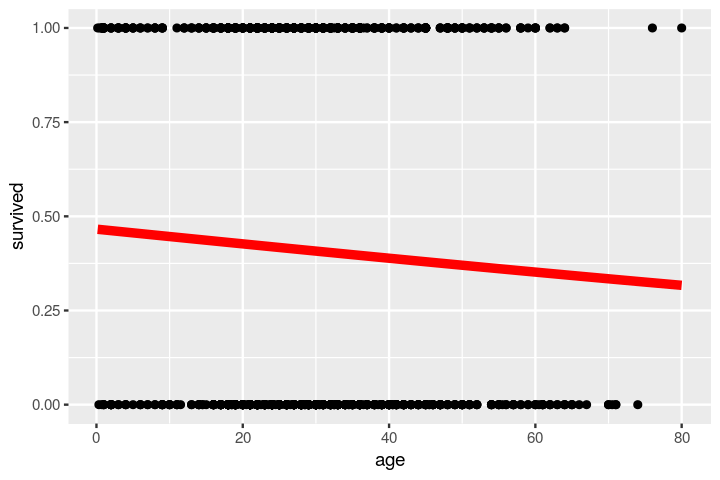

In [8]:
options(repr.plot.width=6, repr.plot.height=4)
grid.glm.malefemale <- dataset %>% data_grid(age) %>% mutate(pred = predict(dataset.model.glm.malefemale, newdata = ., type = 'response'))
ggplot(grid.glm.malefemale) +
  geom_point(
      data = mutate(dataset, survived = as.numeric(levels(survived))[survived]),
      mapping = aes(x = age, y = survived)) +
  geom_line(mapping = aes(x = age, y = pred), color = "red", size = 2)

**Question**

Compare the output values from the model (in red) to the values in the dataset (in black).
What is the model doing that the data is not?  
How would you interpret this? 
Also, speculate on a way that you could use the red curve to predict whether or not a passenger survives.



The model suggests that older people tend to have lower survivability rates. However the model suggests the means of surivorship which is unusual because survivorship is a binary value (either you survive or you don't) but the model suggests a halfway value.

You may interpret this as a probability of the person surviving. So if the 'survived' value on the model is less than .5 that means that person has a higher chance of perishing than surviving.
So if the red line is closer to .25 that means that person probably has a 1/4 chance of surviving but the closer the line is to .5 that means that it is a 1/2 chance that person will survive (so really it is left up to chance).

# Decision Trees

Another method for building predictions are decision trees.
Decision trees are a lot like the `IF()` statement we used in Google Sheets
on Lab Week 3, in that they have several nodes where you ask a if/then style
question, and if you answer "yes" then you go down the *yes* path and if you
answer "no" then you go down the *no* path. In fact, if you wanted to, you
could construct a rudimentary decision tree by hand by nesting several `IF()` 
functions.

However, we will not be attempting to build a decision tree program ourselves,
as there are several convenient packages available that will build decision
trees for you. We use the version that comes as part of R in the `rpart` function.

The code below builds a decision tree based on whether a passenger is male or female.
Run the code to create the model and output a nice graphic that illustrates it's
meaning.

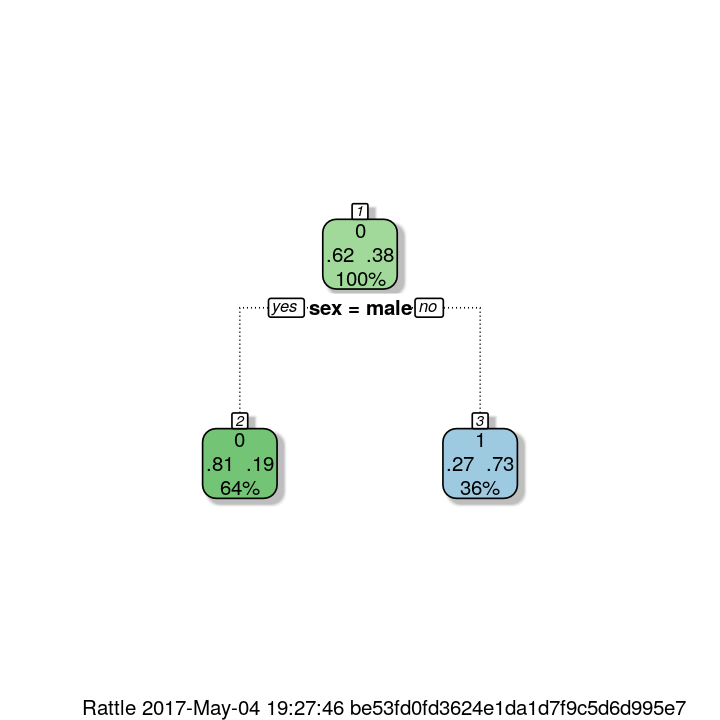

In [13]:
options(repr.plot.width=6, repr.plot.height=6)
fit <- rpart(survived ~ sex,
             data=dataset,
             method="class")
prediction <- predict(fit, dataset, type = "class")
fancyRpartPlot(fit)

The above graphic is read from the top down. It starts by assuming all people perish (the zero at the top), with 62% of the dataset matching this assumption (left decimal) and 38% of the dataset **not** matching this assumption (right decimal). 100% of the passengers start here during the sorting procedure.
The tree then asks a question, "Are you male?" If the passenger data says yes, then the data point is put in the left bucket. If the data says no, then they go to the right. The left bucket predicts the passenger did not survive. 64% of the data is sorted into this bucket. 81% of the male passengers sorted here indeed perished, while 19% did not. In the right bucket, the remaining 36% of passengers, the female passengers, are predicted to survive. 73% of the women survive, 27% do not. For a simple sort, this isn't so bad a prediction model!

Now let's have you try a decision tree model. Copy the code from above, keep the `sex` variable, and add two more variables into it. You should choose from the list:

- pclass
- sibsp
- parch
- fare
- embarked

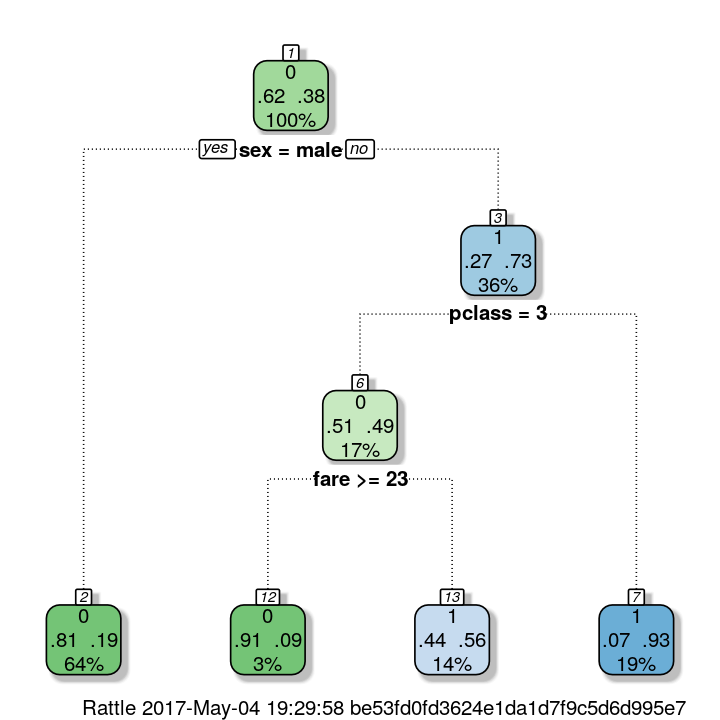

In [15]:
options(repr.plot.width=6, repr.plot.height=6)
fit <- rpart(survived ~ sex + pclass + fare,
             data=dataset,
             method="class")
prediction <- predict(fit, dataset, type = "class")
fancyRpartPlot(fit)

**Question**

How well does your decision tree seem to perform? Just from looking, does it do better or worse than the above model? 

I suppose this model indicates which factors will affect survivorship more. It breaks down the demographics of passengers by probability and percentage of a certain demographic for survivorship. For the females 1/3 of them persihed but 73% did not. For the passenger class equaling 3 and were female, 17% of the data fell into this class while it was nearly a 50:50 chance of passengers in this class would survive while passengers that were in 1st or 2nd class and female, most of them survived. This decision tree is easier to read than a histogram where there is more data as opposed to a decision tree where you can just follow the decision tree to find a demographic of interest and it gives you how many of this demographic survived and how many did not and the percentage of all the data that makes up this demographic.

Using single decision trees seems very nice because its behavior is
easy to interpret, but it turns out that any given tree may not be the most
accurate model. The rules for splitting the variables into different branches
are not absolute, so in principle you could end up with many different types of decision
trees. Instead of trying to iterate through many possible examples, we move on to
a more systematic approach to our modeling.

# Preparing your dataset for testing and prediction

The above examples were meant to illustrate the concepts of generalized linear models and decision trees. While
we could attempt to add and remove variables as a way to manually optimize the model's predictive powers, there
are better, more powerful ways to address this problem using an ensemble version of decision trees called *Random Forest*
and tools such as k-fold cross-validation. For this part, we will utilize the R package `Caret`, which standardizes
a lot of the modeling syntax and automates a lot of the work of training and testing models of different classes.
Max Kuhn, the developer of `Caret`, describes the package as follows:

[From the `Caret` introduction page:](https://topepo.github.io/caret/index.html)
> The `caret` package (short for _C_lassification _A_nd _RE_gression _T_raining) is a set of functions that attempt to streamline the process for creating predictive models. The package contains tools for:

> - data splitting
> - pre-processing
> - feature selection
> - model tuning using resampling
> - variable importance estimation
> - as well as other functionality.

> There are many different modeling functions in R. Some have different syntax for model training and/or prediction. The package started off as a way to provide a uniform interface the functions themselves, as well as a way to standardize common tasks (such parameter tuning and variable importance).

In the long term, if you decide to use of machine learning in your future work, I wouldn't recommend only
using something like `Caret` and never learning more. It's worth digging in to how all of this stuff works,
and will lead to a deeper appreciation and understanding of what's going on. But, for now, we use it
for sake of convenience and to show that you can still do useful things even as you're learning about
the various models that are available.

## Data Cleaning

In order to use the Caret framework, we need to clean up our dataset a little more.
As we're going to use it, `Caret` requires that there are no `NA` values in the columns we use when creating a model.
The `age`, `embarked`, and `fare` columns all contain `NA` values. However, we do not want to just drop these from our dataset, as this will remove significant amounts of information.
Instead, we handle each as follows.

For ages, we can either take the median or mean age from the `age` column, or we can use a decision tree created using `rpart` to assign ages to passengers.
The decision tree route will be a little more robust, so let's use that. Run the following code to train the decision tree on the dataset to predict ages.

In [16]:
# Handle missing data (necessary for random forest)
Agefit <- rpart(age ~ pclass + sex + sibsp + parch + fare + embarked,
                data=dataset[!is.na(dataset$age),], 
                method="anova")

To predict the ages for the missing cells, we simply run:

In [17]:
dataset$age[is.na(dataset$age)] <- predict(Agefit, dataset[is.na(dataset$age),])

For the fares, there's one missing value, so it's easier to just take the median value and use that as an approximate value:

In [18]:
dataset$fare[1226] <- median(dataset$fare, na.rm = TRUE)

For `embarked`, there are two missing values. Of the three departure locations, Southampton is the most common, so let's assign that to the two missing cells:

In [19]:
dataset$embarked[c(169, 285)] = "S"
dataset$embarked <- factor(dataset$embarked)

Now the dataset is ready for model training in `Caret`.

## Subset the data into a training piece and a testing piece

For a proper machine learning study, the dataset should be split into two pieces, the training set where you develop the model,
and the testing set that you try to predict as accurately as possible. We will do an 80/20 split. To do so, run the following code:

**If you would like, you can change the number inside `set.seed()` to change the final splitting of the dataset.**

In [20]:
# define an 80%/20% train/test split of the dataset
set.seed(381710)
split=0.80
trainIndex <- createDataPartition(dataset$passengerid, p=split, list=FALSE)
data_train <- dataset[trainIndex, ]
data_test <- dataset[-trainIndex, ]

## Define our cross-validation method

To get a reasonable estimation of our model's error, we use the *k*-fold cross-validation method.
For this dataset, we set $k=10$ (so, ten-fold), meaning we will have ten testing sets to iterate through.
In addition, to get better statistics, we repeat the k-fold cross-validation process 3 times with different random samples.
The code below sets this up for us.
We also choose the "Accuracy" metric for how we want to measure our model's performance.

**Note:** You will see that, before every model training run, that we run `set.seed(seed)`. The input variable `seed` is defined below.
It is important that the `seed` variable stays the same for all training runs. This has to do with the random number generator
that does the data sampling when building up the k-fold cross-validation. For accurate comparison, we want all models to train against the
same k-fold cross-validation procedures.

In [21]:
control <- trainControl(method="repeatedcv", number=10, repeats=3)
seed <- -4168
metric <- "Accuracy"

# Cross-validated glm model

Now that we're all set up with a training set and a cross-validation method, we 
revisit the glm model and see if we can improve it at all.
To train a more sophisicated glm model, we include all reasonable variables and run the following code. *If you get a series of warning messages, that's okay*.

In [22]:
set.seed(seed)
fit.glm <- train(survived~fare + age + sex + pclass + sibsp + parch + embarked,
                 data=data_train, method="glm", metric=metric, trControl=control)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient 

To make predictions on the testing dataset and evaluate it's accuracy, we run
the following code. It will construct a truth table that indicates the accurate
predictions and the inaccurate ones.

In [23]:
x_test <- data_test %>% select(-survived)
y_test <- data_test %>% select(survived)
glm.predictions <- predict(fit.glm, x_test)
confusionMatrix(table(pred.glm = glm.predictions, truth = y_test$survived))

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

Confusion Matrix and Statistics

        truth
pred.glm   0   1
       0 133  34
       1  23  70
                                          
               Accuracy : 0.7808          
                 95% CI : (0.7255, 0.8295)
    No Information Rate : 0.6             
    P-Value [Acc > NIR] : 4.741e-10       
                                          
                  Kappa : 0.5351          
 Mcnemar's Test P-Value : 0.1853          
                                          
            Sensitivity : 0.8526          
            Specificity : 0.6731          
         Pos Pred Value : 0.7964          
         Neg Pred Value : 0.7527          
             Prevalence : 0.6000          
         Detection Rate : 0.5115          
   Detection Prevalence : 0.6423          
      Balanced Accuracy : 0.7628          
                                          
       'Positive' Class : 0               
                                          

**Question**

What is the prediction accuracy for the model? What is the confidence interval?

The prediction accuracy for the model is 78% and the confidence interval predicts the true value betweeen 72.5% and 82.9%.

# Random Forest

While the glm model is nice in that it ties in directly with the `lm()` models we've been using,
it's not always the best model to use. An alternative is to start with decision trees, but instead of a 
single one, we can instead make **hundreds of decision trees** and then average their parameters to get
a reaonable prediction. One version of this process is called the *Random Forest*. We will use
this and see if it performs better than the glm model.

## Running the random forest model

The code below sets up and runs a random forest model for the same sets of parameters that we initially used for the glm model.
Please note, this is a larger calculation compared with anything else we've done during the course. It will take a few minutes
for this to run. **It is important that you let the algorithm run to completion before you start doing additional work in the
notebook, otherwise it might crash the kernel.**

In [24]:
# Random Forest
set.seed(seed)
fit.rf <- train(survived~fare + age + sex + pclass + sibsp + parch + embarked, 
                data=data_train, method="rf", metric=metric, trControl=control)

For the random forest, if we want to evaluate which parameters are most important, we run the code below.
The more a point slides to the right, the more important
it is.

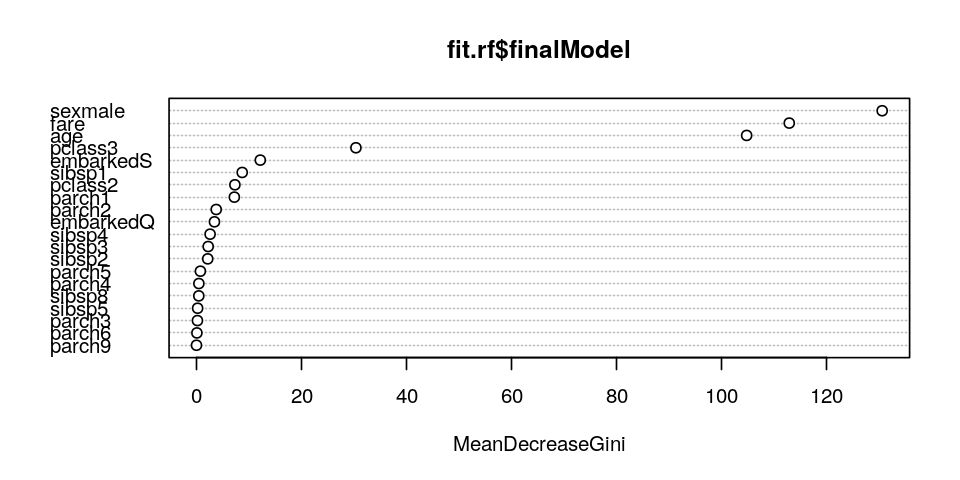

In [25]:
options(repr.plot.width=8, repr.plot.height=4)
varImpPlot(fit.rf$finalModel)

**Question**

Which variables are the most important for predicting whether or not a passenger survives?

It sems that sex, fare, and age are the most important predictors as to whether or not a passenger survives.

Just like with glm, we should make predictions on the test set to see how we've done, predicition-wise.

In [26]:
# make predictions
x_test <- data_test %>% select(-survived)
y_test <- data_test %>% select(survived)
rf.predictions <- predict(fit.rf, x_test)
confusionMatrix(table(pred.rf = rf.predictions, truth = y_test$survived))

Confusion Matrix and Statistics

       truth
pred.rf   0   1
      0 134  36
      1  22  68
                                         
               Accuracy : 0.7769         
                 95% CI : (0.7214, 0.826)
    No Information Rate : 0.6            
    P-Value [Acc > NIR] : 1.124e-09      
                                         
                  Kappa : 0.5246         
 Mcnemar's Test P-Value : 0.08783        
                                         
            Sensitivity : 0.8590         
            Specificity : 0.6538         
         Pos Pred Value : 0.7882         
         Neg Pred Value : 0.7556         
             Prevalence : 0.6000         
         Detection Rate : 0.5154         
   Detection Prevalence : 0.6538         
      Balanced Accuracy : 0.7564         
                                         
       'Positive' Class : 0              
                                         

**Question**

What is the prediction accuracy with the random forest? What is the confidence interval?

The prediction accuracy is 77.7% and the confidence interval predicts that the true value is between 72.14% and 82.6%.

# Comparing the random forest model with the generalized linear model

Finally, we would like to know how the glm and random forest models compare with each other.
The `resamples()` function from `Caret` does some consistency checking and computes
summary statistics about each model so you can make a direct comparison.
The code below handles this:

In [27]:
results <- resamples(list(glm=fit.glm, randomForest=fit.rf))
summary(results)


Call:
summary.resamples(object = results)

Models: glm, randomForest 
Number of resamples: 30 

Accuracy 
               Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
glm          0.7308  0.7619 0.7867 0.7906  0.8113 0.8750    0
randomForest 0.7596  0.7844 0.8000 0.8042  0.8262 0.8585    0

Kappa 
               Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
glm          0.4120  0.4963 0.5447 0.5519  0.6013 0.7204    0
randomForest 0.4624  0.5255 0.5620 0.5726  0.6191 0.6957    0


A convenient method for comparison is to create a "dot-plot" of the *Accuracy* metric.
The closer the *Accuracy* measure is to 1, the better it is. The *Kappa* parameter
is another quantity you can use to compare models. To interpret the outputs:

1. We compare both the mean value of *Accuracy* and *Kappa* for each model as well as the error bars.
2. If the two models have overlapping error bars, then their prediction powers are the same, statistically speaking.
3. If there is a gap between the two models, then we can distinguish between them in terms of predictive powers.

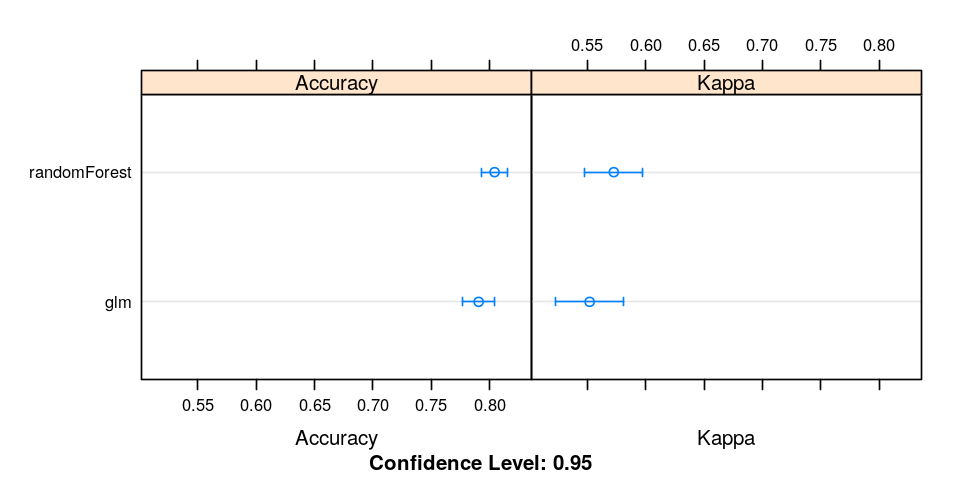

In [28]:
# Dot-plot comparison
options(repr.plot.width=8, repr.plot.height=4)
dotplot(results)

**Question**

Is one model more accurate than the other, or are statistically the same? Do both parameters let you draw the same conclusion?

It seems that they are statistically the same even though the mean accuracy seems to be greater for the randomForest model. Both parameters do allow me to draw the same conclusion.

# Wrap-up

This concludes this tour of doing machine-learning on a real dataset. There's plenty more analysis
that you could do, including checking which passengers are failing the prediction test and trying
to create a new column that could account for this issue, trying out additional models, and
seeing if you can make stronger conclusions about which variables are the most important and why.